# LiDAR-카메라 캘리브레이션

이 노트북에서는 LiDAR와 카메라 간의 캘리브레이션 방법과 원리에 대해 학습하고, 실제 데이터를 활용하여 포인트 클라우드를 카메라 이미지에 투영하는 과정을 구현합니다.

## 학습 목표

- 센서 캘리브레이션의 수학적 기초 이해
- 외부 파라미터(Extrinsic Parameter)와 내부 파라미터(Intrinsic Parameter) 개념 학습
- KITTI 데이터셋의 캘리브레이션 파일 이해
- LiDAR-카메라 캘리브레이션 구현
- 포인트 클라우드의 카메라 이미지 투영
- 캘리브레이션 결과 검증 및 시각화

## 1. 필요한 라이브러리 설치 및 임포트


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
from glob import glob
from PIL import Image

# 프로젝트 루트 경로 추가
current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

# 유틸리티 모듈 임포트
from utils.calibration import (
    load_calib_data,
    lidar_to_camera,
    camera_to_image,
    lidar_to_image,
    get_fov_mask
)

# 시각화 설정
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 2. 캘리브레이션의 수학적 기초

자율주행에서 센서 캘리브레이션은 여러 센서의 데이터를 하나의 좌표계로 통합하여 처리하기 위해 필수적입니다. 

### 좌표계 변환의 수학적 기초

3D 공간에서 한 좌표계(A)에서 다른 좌표계(B)로 변환하기 위해서는 회전(R)과 이동(t)을 모두 고려해야 합니다:

$$P_B = R \cdot P_A + t$$

여기서:
- $P_A$는 좌표계 A에서의 점 위치
- $P_B$는 좌표계 B에서의 점 위치
- $R$은 3x3 회전 행렬
- $t$는 3x1 이동 벡터

동차 좌표계(homogeneous coordinates)를 사용하면 이를 하나의 변환 행렬로 표현할 수 있습니다:

$$\begin{bmatrix} P_B \\ 1 \end{bmatrix} = \begin{bmatrix} R & t \\ 0 & 1 \end{bmatrix} \begin{bmatrix} P_A \\ 1 \end{bmatrix}$$

이 4x4 행렬을 외부 파라미터(extrinsic parameters)라고 합니다.

### 카메라의 내부 파라미터 (Intrinsic Parameters)

카메라의 내부 파라미터는 3D 공간의 점을 카메라 이미지 평면의 2D 좌표로 투영하는 방법을 정의합니다. 

핀홀 카메라 모델에서 내부 파라미터는 다음과 같이 표현됩니다:

$$\begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = \begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} X_c / Z_c \\ Y_c / Z_c \\ 1 \end{bmatrix}$$

여기서:
- $(u, v)$는 이미지 평면의 픽셀 좌표
- $(X_c, Y_c, Z_c)$는 카메라 좌표계에서의 3D 좌표
- $f_x, f_y$는 x와 y 방향의 초점 거리 (픽셀 단위)
- $(c_x, c_y)$는 주점(principal point)의 픽셀 좌표

이 3x3 행렬을 카메라 내부 파라미터 행렬 혹은 캘리브레이션 행렬(calibration matrix)이라고 합니다.

### LiDAR-카메라 캘리브레이션

LiDAR 좌표계의 점을 카메라 이미지에 투영하기 위해서는 다음과 같은 변환 과정이 필요합니다:

1. LiDAR 좌표계 → 카메라 좌표계: 외부 파라미터 행렬 사용
2. 카메라 좌표계 → 이미지 평면: 내부 파라미터 행렬 사용

전체 변환은 다음과 같이 표현됩니다:

$$\begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = P \cdot T_{velo2cam} \cdot \begin{bmatrix} X_v \\ Y_v \\ Z_v \\ 1 \end{bmatrix}$$

여기서:
- $(X_v, Y_v, Z_v)$는 LiDAR 좌표계의 3D 좌표
- $T_{velo2cam}$은 LiDAR 좌표계에서 카메라 좌표계로의 변환 행렬 (4x4)
- $P$는 투영 행렬 (3x4, 내부 파라미터에 기반)
- $(u, v)$는 이미지 평면의 픽셀 좌표

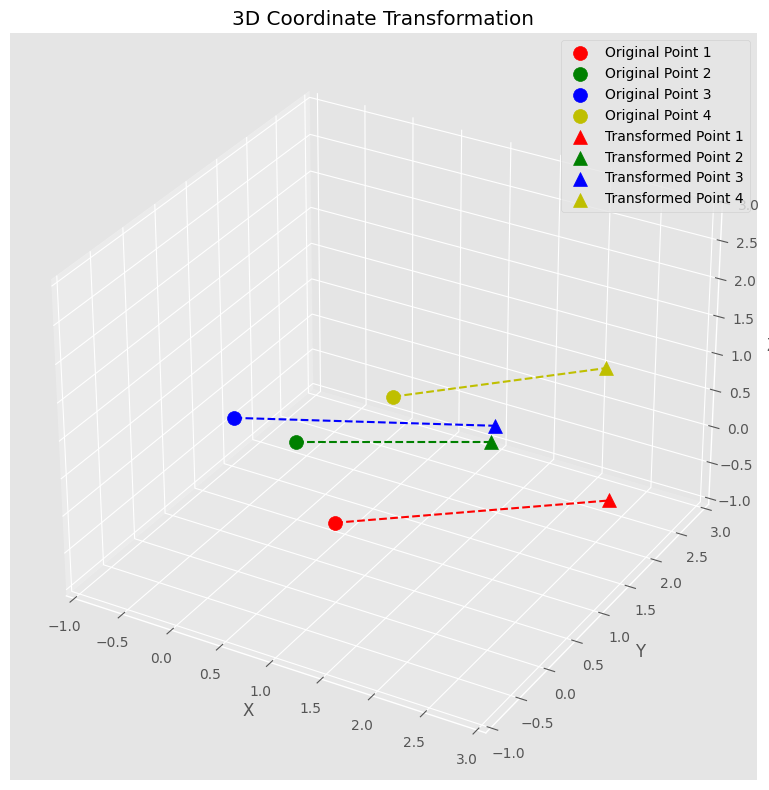

변환 행렬:
[[ 0.8660254 -0.5        0.         2.       ]
 [ 0.5        0.8660254  0.         1.       ]
 [ 0.         0.         1.         0.       ]
 [ 0.         0.         0.         1.       ]]

원본 포인트 vs 변환된 포인트:
Point 1: [1 0 0] -> [2.8660254 1.5       0.       ]
Point 2: [0 1 0] -> [1.5       1.8660254 0.       ]
Point 3: [0 0 1] -> [2. 1. 1.]
Point 4: [1 1 1] -> [2.3660254 2.3660254 1.       ]


In [2]:
# 좌표계 변환 예시 함수
def demonstrate_coordinate_transform():
    """좌표계 변환의 기본 개념을 시각화"""
    # 간단한 예시 데이터 생성
    points_3d = np.array([
        [1, 0, 0],   # 빨간색 포인트
        [0, 1, 0],   # 녹색 포인트
        [0, 0, 1],   # 파란색 포인트
        [1, 1, 1]    # 노란색 포인트
    ])
    
    # 임의의 회전 및 이동 설정
    theta = np.radians(30)  # 30도 회전
    R = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    t = np.array([2, 1, 0])  # x: 2, y: 1 방향으로 이동
    
    # 변환 행렬 생성
    transform = np.eye(4)
    transform[:3, :3] = R
    transform[:3, 3] = t
    
    # 변환 적용
    points_transformed = []
    for point in points_3d:
        # 동차 좌표로 변환
        p_homogeneous = np.append(point, 1)
        # 변환 적용
        p_transformed = transform @ p_homogeneous
        # 다시 3D 좌표로 변환
        points_transformed.append(p_transformed[:3])
    
    points_transformed = np.array(points_transformed)
    
    # 결과 시각화
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # 원본 포인트 플롯
    colors = ['r', 'g', 'b', 'y']
    for i, point in enumerate(points_3d):
        ax.scatter(point[0], point[1], point[2], color=colors[i], marker='o', s=100, label=f'Original Point {i+1}')
    
    # 변환된 포인트 플롯
    for i, point in enumerate(points_transformed):
        ax.scatter(point[0], point[1], point[2], color=colors[i], marker='^', s=100, label=f'Transformed Point {i+1}')
        # 변환 전/후 포인트 연결
        ax.plot([points_3d[i, 0], point[0]], 
                [points_3d[i, 1], point[1]], 
                [points_3d[i, 2], point[2]], 
                color=colors[i], linestyle='--')
    
    # 축 레이블 및 범례
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Coordinate Transformation')
    ax.legend()
    
    # 그리드 및 축 범위 설정
    ax.grid(True)
    ax.set_xlim([-1, 3])
    ax.set_ylim([-1, 3])
    ax.set_zlim([-1, 3])
    
    plt.tight_layout()
    plt.show()
    
    print("변환 행렬:")
    print(transform)
    print("\n원본 포인트 vs 변환된 포인트:")
    for i in range(len(points_3d)):
        print(f"Point {i+1}: {points_3d[i]} -> {points_transformed[i]}")

# 좌표계 변환 시연
demonstrate_coordinate_transform()

## 3. KITTI 데이터셋 로드

KITTI 데이터셋에서 LiDAR 포인트 클라우드, 카메라 이미지, 캘리브레이션 파일을 로드합니다.

/workspaces/autonomous-driving-lidar-demo
경로에 KITTI 데이터가 없습니다. 예시 데이터를 생성합니다...
예시 포인트 클라우드 생성 완료: (10000, 4)
예시 이미지 생성 완료: (375, 1242, 3)
예시 캘리브레이션 데이터 생성 완료


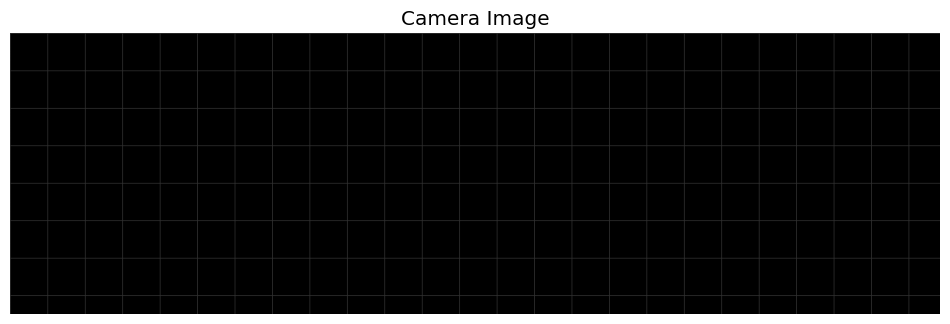

포인트 개수: 10000
X 범위: [-20.00, 20.00]
Y 범위: [-19.99, 20.00]
Z 범위: [-2.00, 5.00]
강도 범위: [0.00, 1.00]


In [5]:
def load_point_cloud(bin_path):
    """
    KITTI bin 형식의 포인트 클라우드 파일 로드
    
    Args:
        bin_path (str): bin 파일 경로
        
    Returns:
        numpy.ndarray: 포인트 클라우드 [N, 4] (x, y, z, intensity)
    """
    # 이진 파일에서 4xN float 배열로 읽기
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return points

def load_image(img_path):
    """
    이미지 파일 로드
    
    Args:
        img_path (str): 이미지 파일 경로
        
    Returns:
        numpy.ndarray: RGB 이미지
    """
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
    return img

# 데이터 경로 설정
# data_dir = '../../data/kitti'
data_dir = os.path.join(parent_dir, 'data')
print(parent_dir)
point_cloud_dir = os.path.join(data_dir, 'velodyne_points')
image_dir = os.path.join(data_dir, 'image_02')
calib_dir = os.path.join(data_dir, 'calib')

# 첫 번째 프레임 로드
frame_id = '0000000000'
point_cloud_path = os.path.join(point_cloud_dir, f'{frame_id}.bin')
image_path = os.path.join(image_dir, f'{frame_id}.png')
calib_path = os.path.join(calib_dir, f'{frame_id}.txt')

# 데이터 로드
if os.path.exists(point_cloud_path) and os.path.exists(image_path) and os.path.exists(calib_path):
    points = load_point_cloud(point_cloud_path)
    image = load_image(image_path)
    calib_data = load_calib_data(calib_path)
    
    print(f"포인트 클라우드 로드 완료: {points.shape}")
    print(f"이미지 로드 완료: {image.shape}")
    print(f"캘리브레이션 데이터 로드 완료: {list(calib_data.keys())}")
else:
    # 데이터가 없는 경우 예시 데이터 생성
    print("경로에 KITTI 데이터가 없습니다. 예시 데이터를 생성합니다...")
    
    # 예시 포인트 클라우드 생성
    num_points = 10000
    x = np.random.uniform(-20, 20, num_points)
    y = np.random.uniform(-20, 20, num_points)
    z = np.random.uniform(-2, 5, num_points)
    intensity = np.random.uniform(0, 1, num_points)
    points = np.column_stack((x, y, z, intensity))
    
    # 예시 이미지 생성 (검은 배경에 그리드)
    image = np.zeros((375, 1242, 3), dtype=np.uint8)
    for i in range(0, image.shape[0], 50):
        cv2.line(image, (0, i), (image.shape[1], i), (50, 50, 50), 1)
    for i in range(0, image.shape[1], 50):
        cv2.line(image, (i, 0), (i, image.shape[0]), (50, 50, 50), 1)
    
    # 예시 캘리브레이션 데이터 생성
    calib_data = {
        'P2': np.array([
            [721.5377, 0.0, 609.5593, 44.85728],
            [0.0, 721.5377, 172.854, 0.2163791],
            [0.0, 0.0, 1.0, 0.002745884]
        ]),
        'R0_rect': np.eye(3),
        'Tr_velo_to_cam': np.array([
            [7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
            [1.480249e-02, 7.280733e-04, -9.998902e-01, -7.631618e-02],
            [9.998621e-01, 7.523790e-03, 1.480755e-02, -2.717806e-01],
            [0.0, 0.0, 0.0, 1.0]
        ])
    }
    
    print(f"예시 포인트 클라우드 생성 완료: {points.shape}")
    print(f"예시 이미지 생성 완료: {image.shape}")
    print(f"예시 캘리브레이션 데이터 생성 완료")

# 데이터 시각화
plt.figure(figsize=(12, 4))
plt.imshow(image)
plt.title('Camera Image')
plt.axis('off')
plt.show()

# 포인트 클라우드 통계
print(f"포인트 개수: {points.shape[0]}")
print(f"X 범위: [{np.min(points[:, 0]):.2f}, {np.max(points[:, 0]):.2f}]")
print(f"Y 범위: [{np.min(points[:, 1]):.2f}, {np.max(points[:, 1]):.2f}]")
print(f"Z 범위: [{np.min(points[:, 2]):.2f}, {np.max(points[:, 2]):.2f}]")
print(f"강도 범위: [{np.min(points[:, 3]):.2f}, {np.max(points[:, 3]):.2f}]")

## 4. KITTI 캘리브레이션 파일 이해

KITTI 데이터셋의 캘리브레이션 파일은 다음과 같은 형식으로 제공됩니다:

```
P0: 7.215377e+02 0.000000e+00 6.095593e+02 0.000000e+00 0.000000e+00 7.215377e+02 1.728540e+02 0.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00
P1: 7.215377e+02 0.000000e+00 6.095593e+02 -3.875744e+02 0.000000e+00 7.215377e+02 1.728540e+02 0.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00
P2: 7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01 0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01 0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03
P3: 7.215377e+02 0.000000e+00 6.095593e+02 -3.395242e+02 0.000000e+00 7.215377e+02 1.728540e+02 2.199936e+00 0.000000e+00 0.000000e+00 1.000000e+00 2.729905e-03
R0_rect: 9.999239e-01 9.837760e-03 -7.445048e-03 -9.869795e-03 9.999421e-01 -4.278459e-03 7.402527e-03 4.351614e-03 9.999631e-01
Tr_velo_to_cam: 7.533745e-03 -9.999714e-01 -6.166020e-04 -4.069766e-03 1.480249e-02 7.280733e-04 -9.998902e-01 -7.631618e-02 9.998621e-01 7.523790e-03 1.480755e-02 -2.717806e-01
Tr_imu_to_velo: 9.999976e-01 7.553071e-04 -2.035826e-03 -8.086759e-01 -7.854027e-04 9.998898e-01 -1.482298e-02 3.195559e-01 2.024406e-03 1.482454e-02 9.998881e-01 -7.997231e-01
```

각 행의 의미는 다음과 같습니다:

- `P0`, `P1`, `P2`, `P3`: 각 카메라(0: 왼쪽 회색, 1: 오른쪽 회색, 2: 왼쪽 컬러, 3: 오른쪽 컬러)의 투영 행렬 (3x4)
- `R0_rect`: 회전 정류화(rectification) 행렬 (3x3)
- `Tr_velo_to_cam`: LiDAR에서 카메라로의 변환 행렬 (3x4)
- `Tr_imu_to_velo`: IMU에서 LiDAR로의 변환 행렬 (3x4)

In [5]:
# 캘리브레이션 데이터 분석
if calib_data:
    # P2 (왼쪽 컬러 카메라의 투영 행렬) 분석
    P2 = calib_data['P2']
    print("P2 (왼쪽 컬러 카메라 투영 행렬):")
    print(P2)
    print(f"내부 파라미터: fx={P2[0, 0]}, fy={P2[1, 1]}, cx={P2[0, 2]}, cy={P2[1, 2]}")
    print(f"기준선(baseline) 효과: tx={P2[0, 3]}")
    
    # R0_rect (정류화 행렬) 분석
    R0_rect = calib_data['R0_rect']
    print("\nR0_rect (정류화 행렬):")
    print(R0_rect)
    
    # Tr_velo_to_cam (LiDAR에서 카메라로의 변환 행렬) 분석
    Tr_velo_to_cam = calib_data['Tr_velo_to_cam']
    print("\nTr_velo_to_cam (LiDAR에서 카메라로의 변환 행렬):")
    print(Tr_velo_to_cam)
    print(f"회전 행렬:\n{Tr_velo_to_cam[:3, :3]}")
    print(f"이동 벡터: {Tr_velo_to_cam[:3, 3]}")

P2 (왼쪽 컬러 카메라 투영 행렬):
[[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]
내부 파라미터: fx=721.5377, fy=721.5377, cx=609.5593, cy=172.854
기준선(baseline) 효과: tx=44.85728

R0_rect (정류화 행렬):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Tr_velo_to_cam (LiDAR에서 카메라로의 변환 행렬):
[[ 7.533745e-03 -9.999714e-01 -6.166020e-04 -4.069766e-03]
 [ 1.480249e-02  7.280733e-04 -9.998902e-01 -7.631618e-02]
 [ 9.998621e-01  7.523790e-03  1.480755e-02 -2.717806e-01]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]
회전 행렬:
[[ 7.533745e-03 -9.999714e-01 -6.166020e-04]
 [ 1.480249e-02  7.280733e-04 -9.998902e-01]
 [ 9.998621e-01  7.523790e-03  1.480755e-02]]
이동 벡터: [-0.00406977 -0.07631618 -0.2717806 ]


## 5. LiDAR에서 카메라로의 변환

LiDAR 좌표계에서 카메라 좌표계로 포인트 클라우드를 변환합니다.

In [6]:
# LiDAR에서 카메라 좌표계로 변환
points_camera = lidar_to_camera(points, calib_data)

print(f"카메라 좌표계로 변환된 포인트: {points_camera.shape}")
print(f"X 범위: [{np.min(points_camera[:, 0]):.2f}, {np.max(points_camera[:, 0]):.2f}]")
print(f"Y 범위: [{np.min(points_camera[:, 1]):.2f}, {np.max(points_camera[:, 1]):.2f}]")
print(f"Z 범위: [{np.min(points_camera[:, 2]):.2f}, {np.max(points_camera[:, 2]):.2f}]")

# 변환 결과 시각화
plt.figure(figsize=(10, 8))
plt.scatter(points_camera[:, 0], points_camera[:, 1], c=points_camera[:, 2], s=0.5, cmap='viridis')
plt.colorbar(label='Z (m)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Point Cloud in Camera Coordinate System')
plt.axis('equal')
plt.grid(True)
plt.show()

NameError: name 'lidar_to_camera' is not defined

## 6. 카메라 좌표계에서 이미지 평면으로 투영

카메라 좌표계의 포인트를 이미지 평면의 픽셀 좌표로 투영합니다.


In [7]:
# 카메라 좌표계에서 이미지 평면으로 투영
points_image = camera_to_image(points_camera, calib_data)

print(f"이미지 평면으로 투영된 포인트: {points_image.shape}")
print(f"u 범위: [{np.min(points_image[:, 0]):.2f}, {np.max(points_image[:, 0]):.2f}]")
print(f"v 범위: [{np.min(points_image[:, 1]):.2f}, {np.max(points_image[:, 1]):.2f}]")

# 이미지 크기 확인
image_height, image_width = image.shape[:2]
print(f"이미지 크기: {image_width}x{image_height}")

# 시야각(FOV) 마스크 생성
fov_mask = get_fov_mask(points_image, points_camera, (image_height, image_width))
print(f"시야각 내 포인트 수: {np.sum(fov_mask)}")

# 시야각 내 포인트만 필터링
points_fov = points[fov_mask]
points_image_fov = points_image[fov_mask]
points_camera_fov = points_camera[fov_mask]

NameError: name 'camera_to_image' is not defined

## 7. 투영 결과 시각화

LiDAR 포인트 클라우드를 카메라 이미지에 투영한 결과를 시각화합니다.


In [8]:
# 포인트 클라우드를 이미지에 투영하여 시각화
def visualize_lidar_on_image(image, points_image, points_camera, max_depth=100):
    """
    LiDAR 포인트 클라우드를 이미지에 투영하여 시각화
    
    Args:
        image (numpy.ndarray): 카메라 이미지
        points_image (numpy.ndarray): 이미지 평면의 픽셀 좌표 [N, 2]
        points_camera (numpy.ndarray): 카메라 좌표계의 포인트 [N, 3]
        max_depth (float): 최대 깊이 (색상 정규화용)
    """
    # 이미지 복사
    img_vis = image.copy()
    
    # 포인트 깊이 (Z) 이용하여 색상 결정
    depths = points_camera[:, 2]
    
    # 가까운 포인트가 더 밝게 표시되도록 색상 정규화
    # Z가 작을수록 (가까울수록) 노란색 ~ 빨간색
    # Z가 클수록 (멀수록) 파란색 ~ 보라색
    norm_depths = depths / max_depth
    norm_depths = np.clip(norm_depths, 0, 1)
    
    # 색상 매핑
    colormap = plt.cm.plasma
    colors = colormap(norm_depths)[:, :3] * 255
    
    # 각 포인트를 이미지에 그리기
    for i in range(len(points_image)):
        x, y = points_image[i].astype(int)
        
        # 이미지 범위 내인지 확인
        if 0 <= x < img_vis.shape[1] and 0 <= y < img_vis.shape[0]:
            cv2.circle(img_vis, (x, y), 1, colors[i], -1)
    
    # 결과 시각화
    plt.figure(figsize=(14, 7))
    plt.imshow(img_vis)
    plt.title('LiDAR Points Projected on Camera Image')
    plt.axis('off')
    
    # 깊이 컬러바 추가
    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('Depth (m)')
    cbar.set_ticks(np.linspace(0, 1, 5))
    cbar.set_ticklabels([f"{i * max_depth / 4:.1f}" for i in range(5)])
    
    plt.tight_layout()
    plt.show()
    
    return img_vis

# 포인트 클라우드 투영 시각화
visualize_lidar_on_image(image, points_image_fov, points_camera_fov)


NameError: name 'points_image_fov' is not defined

## 8. 거리에 따른 포인트 색상 시각화

포인트 클라우드의 거리(depth)에 따라 색상을 다르게 표현하여 3D 정보를 이미지에 시각화합니다.


In [9]:
# 깊이 기반 시각화 (여러 깊이 범위로 구분하여 시각화)
def visualize_depth_ranges(image, points_image, points_camera, depth_ranges):
    """
    깊이 범위별로 색상을 구분하여 LiDAR 포인트 클라우드 시각화
    
    Args:
        image (numpy.ndarray): 카메라 이미지
        points_image (numpy.ndarray): 이미지 평면의 픽셀 좌표 [N, 2]
        points_camera (numpy.ndarray): 카메라 좌표계의 포인트 [N, 3]
        depth_ranges (list): 깊이 범위 구간 리스트 (예: [0, 10, 20, 30, 40])
    """
    # 이미지 복사
    img_vis = image.copy()
    
    # 각 깊이 범위에 대한 색상 정의
    colors = [
        (255, 0, 0),   # 빨강 (가장 가까운 거리)
        (255, 255, 0), # 노랑
        (0, 255, 0),   # 초록
        (0, 255, 255), # 청록
        (0, 0, 255)    # 파랑 (가장 먼 거리)
    ]
    
    # 깊이 값 추출
    depths = points_camera[:, 2]
    
    # 각 깊이 범위별로 포인트 그리기
    for i in range(len(depth_ranges)-1):
        # 해당 깊이 범위에 있는 포인트 마스크
        mask = (depths >= depth_ranges[i]) & (depths < depth_ranges[i+1])
        
        # 마스크에 해당하는 포인트 추출
        pts_img = points_image[mask]
        
        # 각 포인트 그리기
        for pt in pts_img:
            x, y = pt.astype(int)
            if 0 <= x < img_vis.shape[1] and 0 <= y < img_vis.shape[0]:
                cv2.circle(img_vis, (x, y), 2, colors[i], -1)
    
    # 결과 시각화
    plt.figure(figsize=(14, 7))
    plt.imshow(img_vis)
    plt.title('LiDAR Points by Depth Ranges')
    plt.axis('off')
    
    # 범례 추가
    legend_elements = []
    for i in range(len(depth_ranges)-1):
        # RGB -> matplotlib color format (0-1 범위)
        color_rgb = [c/255 for c in colors[i]]
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                         markerfacecolor=color_rgb, markersize=10, 
                                         label=f'{depth_ranges[i]}m ~ {depth_ranges[i+1]}m'))
    
    plt.legend(handles=legend_elements, loc='upper right')
    plt.tight_layout()
    plt.show()
    
    return img_vis

# 깊이 범위 정의
depth_ranges = [0, 10, 20, 30, 40, 100]

# 깊이 범위별 시각화
visualize_depth_ranges(image, points_image_fov, points_camera_fov, depth_ranges)


NameError: name 'points_image_fov' is not defined

## 9. 직접 LiDAR에서 이미지로 투영

이제 utils 모듈의 `lidar_to_image` 함수를 사용하여 LiDAR 포인트 클라우드를 직접 이미지 평면으로 투영해 봅니다.


In [10]:
# LiDAR 포인트 클라우드를 직접 이미지 평면으로 투영
points_img_direct, points_cam_direct = lidar_to_image(points, calib_data)

# 이미지 범위 내의 포인트만 필터링
fov_mask_direct = get_fov_mask(points_img_direct, points_cam_direct, (image_height, image_width))
points_img_fov_direct = points_img_direct[fov_mask_direct]
points_cam_fov_direct = points_cam_direct[fov_mask_direct]

print(f"직접 투영된 포인트 수: {len(points_img_fov_direct)}")

# 결과 시각화
visualize_lidar_on_image(image, points_img_fov_direct, points_cam_fov_direct)


NameError: name 'lidar_to_image' is not defined

## 10. 심화: 3D 바운딩 박스 투영

이제 3D 바운딩 박스를.이미지에 투영하는 과정을 구현합니다. 이는 객체 검출 및 추적에서 중요한 요소입니다.

In [11]:
def draw_3d_box(image, box_3d, calib_data, color=(0, 255, 0), thickness=2):
    """
    3D 바운딩 박스를 이미지에 투영하여 그리기
    
    Args:
        image (numpy.ndarray): 카메라 이미지
        box_3d (dict): 3D 바운딩 박스 정보 (center, dimensions, rotation_y)
        calib_data (dict): 캘리브레이션 데이터
        color (tuple): 박스 색상 (BGR)
        thickness (int): 선 두께
        
    Returns:
        numpy.ndarray: 박스가 그려진 이미지
    """
    # 이미지 복사
    img_vis = image.copy()
    
    # 박스 정보 추출
    center = box_3d['center']  # 박스 중심 [x, y, z]
    dimensions = box_3d['dimensions']  # 박스 크기 [length, height, width]
    rotation_y = box_3d['rotation_y']  # y축 기준 회전 각도
    
    # 박스 길이, 높이, 폭
    length, height, width = dimensions
    
    # 회전 행렬 생성 (y축 기준)
    R = np.array([
        [np.cos(rotation_y), 0, np.sin(rotation_y)],
        [0, 1, 0],
        [-np.sin(rotation_y), 0, np.cos(rotation_y)]
    ])
    
    # 박스의 8개 코너 포인트 생성 (바닥 4개, 천장 4개)
    x_corners = np.array([length/2, length/2, -length/2, -length/2, length/2, length/2, -length/2, -length/2])
    y_corners = np.array([0, 0, 0, 0, -height, -height, -height, -height])  # 바닥면이 원점
    z_corners = np.array([width/2, -width/2, -width/2, width/2, width/2, -width/2, -width/2, width/2])
    
    # 회전 및 이동 적용
    corners_3d = np.vstack([x_corners, y_corners, z_corners])
    corners_3d = R @ corners_3d
    corners_3d[0, :] = corners_3d[0, :] + center[0]
    corners_3d[1, :] = corners_3d[1, :] + center[1]
    corners_3d[2, :] = corners_3d[2, :] + center[2]
    
    # 이미지 평면으로 투영
    corners_2d = []
    for i in range(8):
        point_3d = corners_3d[:, i]
        point_2d = camera_to_image(np.array([point_3d]), calib_data)[0]
        corners_2d.append(point_2d)
    
    corners_2d = np.array(corners_2d).astype(np.int32)
    
    # 박스 선 그리기
    def draw_line(img, p1, p2, color, thickness):
        cv2.line(img, tuple(p1), tuple(p2), color, thickness)
    
    # 바닥면
    draw_line(img_vis, corners_2d[0], corners_2d[1], color, thickness)
    draw_line(img_vis, corners_2d[1], corners_2d[2], color, thickness)
    draw_line(img_vis, corners_2d[2], corners_2d[3], color, thickness)
    draw_line(img_vis, corners_2d[3], corners_2d[0], color, thickness)
    
    # 천장면
    draw_line(img_vis, corners_2d[4], corners_2d[5], color, thickness)
    draw_line(img_vis, corners_2d[5], corners_2d[6], color, thickness)
    draw_line(img_vis, corners_2d[6], corners_2d[7], color, thickness)
    draw_line(img_vis, corners_2d[7], corners_2d[4], color, thickness)
    
    # 기둥
    draw_line(img_vis, corners_2d[0], corners_2d[4], color, thickness)
    draw_line(img_vis, corners_2d[1], corners_2d[5], color, thickness)
    draw_line(img_vis, corners_2d[2], corners_2d[6], color, thickness)
    draw_line(img_vis, corners_2d[3], corners_2d[7], color, thickness)
    
    return img_vis

# 샘플 3D 바운딩 박스 정의
sample_boxes = [
    {
        'center': np.array([2.0, 0.5, 15.0]),  # [x, y, z] in camera coordinate
        'dimensions': np.array([4.0, 1.5, 1.8]),  # [length, height, width]
        'rotation_y': np.radians(10)  # rotation around y-axis
    },
    {
        'center': np.array([-1.5, 0.5, 25.0]),
        'dimensions': np.array([4.5, 1.8, 2.0]),
        'rotation_y': np.radians(-15)
    }
]

# 3D 바운딩 박스 투영 및 시각화
img_with_boxes = image.copy()

for i, box in enumerate(sample_boxes):
    # 다른 색상으로 각 박스 그리기
    color = (0, 255, 0) if i == 0 else (255, 0, 0)
    img_with_boxes = draw_3d_box(img_with_boxes, box, calib_data, color=color)

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.imshow(img_with_boxes)
plt.title('3D Bounding Boxes Projected to Image')
plt.axis('off')
plt.tight_layout()
plt.show()

NameError: name 'camera_to_image' is not defined

## 11. 여러 프레임에 대한 캘리브레이션 적용

이제 여러 프레임에 대해 캘리브레이션을 적용하고 결과를 확인해봅니다.

In [12]:
def process_multiple_frames(frame_ids, data_dir):
    """
    여러 프레임에 대해 LiDAR-카메라 캘리브레이션 적용
    
    Args:
        frame_ids (list): 처리할 프레임 ID 리스트
        data_dir (str): 데이터 디렉토리 경로
    """
    results = []
    
    for frame_id in frame_ids:
        frame_id_str = f'{frame_id:06d}'
        
        # 파일 경로 설정
        point_cloud_path = os.path.join(data_dir, 'training', 'velodyne', f'{frame_id_str}.bin')
        image_path = os.path.join(data_dir, 'training', 'image_2', f'{frame_id_str}.png')
        calib_path = os.path.join(data_dir, 'training', 'calib', f'{frame_id_str}.txt')
        
        # 파일 존재 확인
        if not (os.path.exists(point_cloud_path) and os.path.exists(image_path) and os.path.exists(calib_path)):
            print(f"프레임 {frame_id_str}의 일부 파일이 없습니다. 건너뜁니다.")
            continue
        
        # 데이터 로드
        try:
            points = load_point_cloud(point_cloud_path)
            image = load_image(image_path)
            calib_data = load_calib_data(calib_path)
            
            # LiDAR 포인트 클라우드를 이미지에 투영
            points_img, points_cam = lidar_to_image(points, calib_data)
            
            # 이미지 범위 내 포인트 필터링
            fov_mask = get_fov_mask(points_img, points_cam, (image.shape[0], image.shape[1]))
            points_img_fov = points_img[fov_mask]
            points_cam_fov = points_cam[fov_mask]
            
            # 투영 이미지 생성
            img_vis = visualize_lidar_on_image(image, points_img_fov, points_cam_fov)
            
            # 결과 저장
            results.append({
                'frame_id': frame_id_str,
                'image': image,
                'points': points,
                'calib_data': calib_data,
                'projection_result': img_vis
            })
            
            print(f"프레임 {frame_id_str} 처리 완료")
        except Exception as e:
            print(f"프레임 {frame_id_str} 처리 중 오류 발생: {e}")
    
    return results

# 여러 프레임 처리 (데이터가 있는 경우에만 실행)
if os.path.exists(os.path.join(data_dir, 'training', 'velodyne')):
    # 처리할 프레임 ID 목록
    frame_ids_to_process = [0, 10, 20]  # 예시: 첫 3개 프레임
    
    # 여러 프레임 처리
    multi_frame_results = process_multiple_frames(frame_ids_to_process, data_dir)
    
    # 결과 시각화 (첫 번째 프레임만)
    if multi_frame_results:
        plt.figure(figsize=(14, 7))
        plt.imshow(multi_frame_results[0]['projection_result'])
        plt.title(f"Frame {multi_frame_results[0]['frame_id']} - LiDAR Projection")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
else:
    print("여러 프레임 처리를 위한 데이터가 없습니다.")

여러 프레임 처리를 위한 데이터가 없습니다.


## 12. 요약 및 결론

이 노트북에서는 LiDAR와 카메라 간의 캘리브레이션 방법과 원리를 학습하고, 실제 데이터를 활용하여 포인트 클라우드를 카메라 이미지에 투영하는 과정을 구현했습니다.

주요 학습 내용:

1. 센서 캘리브레이션의 수학적 기초 (좌표계 변환, 회전, 이동)
2. 카메라의 내부 파라미터와 외부 파라미터 개념
3. KITTI 데이터셋의 캘리브레이션 파일 구조 및 의미
4. LiDAR 포인트 클라우드를 카메라 이미지에 투영하는 과정
5. 3D 바운딩 박스를 2D 이미지에 투영하는 방법

LiDAR-카메라 캘리브레이션은 자율주행 시스템에서 센서 융합의 기초가 되며, 객체 검출, 추적, 맵핑 등 다양한 인지 작업에 활용됩니다.

## 다음 단계

- 다양한 도로 조건에서의 캘리브레이션 정확도 평가
- 온라인 캘리브레이션(자동 캘리브레이션) 기법 연구
- 캘리브레이션 오차가 객체 검출 성능에 미치는 영향 분석
- 다양한 센서(LiDAR, 카메라, 레이더 등)를 포함한 멀티모달 캘리브레이션 
